In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import logging
from msig import Motif, NullModel


results_dir = '../results/household/'
images_dir = '../images/household/'
data_dir = '../data/household/'

In [11]:
df_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity
timestamp,,,,
2008-09-01 00:00:00,1.300,0.000,243.04,5.4
2008-09-01 00:01:00,1.282,0.000,243.30,5.2
2008-09-01 00:02:00,1.302,0.000,243.40,5.2
2008-09-01 00:03:00,1.284,0.000,243.47,5.2
2008-09-01 00:04:00,1.304,0.000,243.55,5.4
...,...,...,...,...
2008-10-24 23:55:00,0.682,0.000,243.84,2.8
2008-10-24 23:56:00,0.630,0.064,244.69,2.6
2008-10-24 23:57:00,0.620,0.080,245.20,2.6


In [2]:
from ucimlrepo import fetch_ucirepo

# # fetch dataset
# individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data = individual_household_electric_power_consumption.data.features
# # date and time col to timestamp
# data["timestamp"] = pd.to_datetime(
#     data["Date"] + " " + data["Time"], format="%d/%m/%Y %H:%M:%S"
# )
# data = data.set_index("timestamp")
# data = data.resample("1min").last().ffill()
# # largest sequence without nans
# data = data.loc["2008-09-01":"2008-10-24"]
# labels = data[["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]]
# labels = labels.astype(float)
# labels.to_csv(data_dir + 'labels.csv')
# # labels = labels.map(lambda x: 1 if float(x) > 0 else 0)
# data = data.drop(
#     columns=["Date", "Time", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
# )
# data.replace("?", np.nan, inplace=True)  # missing values
# data = data.astype(float)

# #save data 
# data.to_csv(data_dir + 'data.csv')


#load data as 
df_data = pd.read_csv(data_dir + 'data.csv', index_col=0).astype(float)

labels = pd.read_csv(data_dir + 'labels.csv', index_col=0).astype(float)
data = df_data.values.T
data 


/home/mgsilva/miniconda3/envs/torch_motifpredenv/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


array([[1.3000e+00, 1.2820e+00, 1.3020e+00, ..., 6.2000e-01, 6.2000e-01,
        6.1800e-01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 8.0000e-02, 8.0000e-02,
        8.0000e-02],
       [2.4304e+02, 2.4330e+02, 2.4340e+02, ..., 2.4520e+02, 2.4515e+02,
        2.4490e+02],
       [5.4000e+00, 5.2000e+00, 5.2000e+00, ..., 2.6000e+00, 2.6000e+00,
        2.6000e+00]])

In [3]:
sr = 1 / 60
# create folders in results path
if not os.path.exists(results_dir):
    os.makedirs(results_dir + "/mp")
    os.makedirs(results_dir + "/mp_indices")

In [4]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
top_k_mp = 1
include = None
normalize = False
subsequence_lengths = [ 60 * 6]  # 1h, 3h, 6h


for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(data, m, normalize=normalize)
    np.save(
        results_dir
        + "/mp/normalized={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        mp,
        allow_pickle=True,
    )
    np.save(
        results_dir
        + "/mp_indices/normalized={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        mp_indices,
        allow_pickle=True,
    )

In [5]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    k_distances,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k_distances",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        if k_distances is None:  # consider all matches
            med_dist = np.median(match_distances[1:])
        else:  # consider only the k closest matches
            med_dist = np.median(match_distances[1 : k_distances + 1])

        # np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
        if max_allowed_dist is None:
            current_data = data[dimensions]
            n_vars, n_time = current_data.shape

            # D The distance profile of `Q` with `T`. It is a 1D numpy array of size
            # `len(T)-len(Q)+1`, where `D[i]` is the distance between query `Q` and
            # `T[i : i + len(Q)]`
            D = np.empty((n_vars, n_time - m + 1))
            for i in range(n_vars):
                D[i, :] = stumpy.mass(
                    multivar_subsequence[i], current_data[i], normalize=normalize
                )
            D = np.mean(D, axis=0)
            D_copy = D.copy().astype(np.float64)
            D_copy[np.isinf(D_copy)] = np.nan
            motif_max_allowed_dist = np.nanmax(
                [np.nanmean(D_copy) - 2.0 * np.nanstd(D_copy), np.nanmin(D_copy)]
            )
        else:
            motif_max_allowed_dist = max_allowed_dist

        unified_weights = "0.33,0.33,0.33"
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / motif_max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = motif_max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(motif_max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [6]:
k_distances = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
k = None
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    X = data
    mp = np.load(
        results_dir
        + "/mp/normalized={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        allow_pickle=True,
    )
    mp_indices = np.load(
        results_dir
        + "/mp_indices/normalized={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        allow_pickle=True,
    )

    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(
        X,
        mp,
        mp_indices,
        min_neighbors=min_neighbors,
        max_distance=max_distance,
        cutoffs=np.inf,
        max_matches=max_matches,
        max_motifs=max_motifs,
        k=k,
        include=include,
        normalize=normalize,
    )

    if len(motif_indices[0]) == 0:
        continue
    table = table_summary_motifs(
        motif_indices,
        motif_distances,
        motif_subspaces,
        X,
        k_distances,
        m,
        normalize,
        max_distance,
    )
    logging.info(
        "m:{}, #Motifs:{}, Sig:{}".format(
            m, len(motif_indices), np.sum(table["p-value"] < 0.001)
        )
    )
    # hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
    sig = (
        table["p-value"] < critical_value
        if critical_value != 0
        else table["p-value"] <= critical_value
    )
    table["Sig_Hochber"] = sig
    logging.info(
        "Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value)
    )
    mp_stats_table = (
        table
        if mp_stats_table.empty
        else pd.concat([mp_stats_table, table], ignore_index=True)
    )

    mp_stats_table.to_csv(
        results_dir
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
            normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
        ),
        index=False,
    )

In [7]:
# create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std,
# average probability +- std, average pvalue +- std)

mp_stats_table = pd.read_csv(
    results_dir
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)
motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(
    columns=[
        "m",
        "#motifs",
        "avg_n_matches",
        "avg_n_features",
        "avg_probability",
        "avg_pvalue",
        "#sig_motifs(<0.01)",
        "significant",
        "#sig_hochberg",
    ]
)
for m in subsequence_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    if table.empty:
        continue
    n_motifs = table.shape[0]
    n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
    avg_n_matches = (
        round(table["#Matches"].mean(), 2),
        round(table["#Matches"].std(), 3),
    )
    avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
    avg_probability = table["P"].mean(), table["P"].std()
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {
        "m": m,
        "#motifs": n_motifs,
        "#sig_motifs(<0.001)": n_sig_motifs_0001,
        "significant": (n_sig_motifs_0001 * 100) / n_motifs,
        "avg_n_matches": avg_n_matches,
        "avg_n_features": avg_n_features,
    }

    motif_stats_table = (
        pd.DataFrame.from_records([stats_df])
        if motif_stats_table.empty
        else pd.concat(
            [motif_stats_table, pd.DataFrame.from_records([stats_df])],
            ignore_index=True,
        )
    )
print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
360 & 57 & 57 & 100.000 & (13.25, 11.887) & (3.77, 0.423) \\
\bottomrule
\end{tabular}



In [8]:
mp_stats_table = pd.read_csv(
    results_dir
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)
# excluded p-value > 0.001
mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
subsequence_lengths = mp_stats_table["m"].unique()
for m in subsequence_lengths:
    print("########## m:{} #########".format(m))
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
    top_motifs = top_motifs[
        [
            "ID",
            "#Matches",
            "CE",
            "Score Unified",
            "max(dists)",
            "min(dists)",
            "med(dists)",
            "p-value",
            "Explained Var(%)",
        ]
    ]
    top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
    print(top_motifs.to_latex(index=False, float_format="%.3f"))
    print("\n")

########## m:360 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
20 & 10 & 0.076 & 0.094 & 26.951 & 20.870 & 22.181 & 0.00e+00 & 5.730 \\
38 & 57 & 0.061 & 0.089 & 42.116 & 29.258 & 38.992 & 0.00e+00 & 29.980 \\
28 & 28 & 0.082 & 0.083 & 33.269 & 23.473 & 30.271 & 0.00e+00 & 16.490 \\
13 & 4 & 0.067 & 0.077 & 22.134 & 18.527 & 20.837 & 0.00e+00 & 1.990 \\
23 & 27 & 0.053 & 0.075 & 31.488 & 21.210 & 28.111 & 0.00e+00 & 12.820 \\
\bottomrule
\end{tabular}





In [9]:
def plot_motif(ts_list, features, m, motif_indexes, motif_name):
    # Generate the time range starting at 2008-09-01 00:00:00 with 77760 minutes
    start_time = pd.Timestamp("2008-09-01 00:00:00")
    time_range = pd.date_range(start=start_time, periods=77760, freq="min")

    # Define 5 equally spaced indices for xticks on the right plots
    xtick_indices = np.linspace(0, len(time_range) - 1, 5, dtype=int)
    xtick_labels = [
        time_range[idx].strftime("%d,%b \n %H:%M:%S") for idx in xtick_indices
    ]

    fig, axes = plt.subplots(
        ncols=2, nrows=len(ts_list), figsize=(10, 2 * len(ts_list)), squeeze=False
    )

    for i in range(len(ts_list)):
        ts = ts_list[i]
        # plot light grey on the right side
        axes[i, 1].plot(ts, color="black", linewidth=0.5, alpha=0.5)

        # Set unique colors for motifs
        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i, 0].set_prop_cycle("color", colors)
        axes[i, 1].set_prop_cycle("color", colors)

        # Plot motifs on the left and highlight on the right
        for index in motif_indexes:
            subsequence_match = ts.iloc[index : index + m]
            axes[i, 0].plot(subsequence_match.values)  # Ensure left plot is drawn
            axes[i, 1].plot(subsequence_match, linewidth=2)

        # Set y-axis labels for left plot
        # Split long y-axis labels (e.g., those with 3 words) into multiple lines
        words = features[i].split()
        if len(words) == 3:
            wrapped_label = (
                f"{' '.join(words[:-1])}\n{words[-1]}"  # Add \n before the last word
            )
        else:
            wrapped_label = features[i]  # No line break for 2 words or less

        # Set y-axis labels for left plot
        axes[i, 0].set_ylabel(wrapped_label, rotation=90, size="large")
        xticks = [0] + list(range(max(1, m // 5), m - 1, max(1, m // 5))) + [m - 1]
        xticklabels = ["i"] + [f"i+{t}" for t in xticks[1:-1]] + [f"i+{m-1}"]

        axes[i, 0].set_xticks(xticks)
        axes[i, 0].set_xticklabels(xticklabels)
        plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=90)

        # Add custom xticks and labels to the right plots
        axes[i, 1].set_xticks(xtick_indices)
        axes[i, 1].set_xticklabels(xtick_labels, rotation=45)

        # Only display x-axis on the last row of plots
        if i != len(ts_list) - 1:
            axes[i, 0].axes.get_xaxis().set_visible(False)
            axes[i, 1].axes.get_xaxis().set_visible(False)

    # Set titles for the two columns
    axes[0, 0].set_title("Raw Subsequences")
    axes[0, 1].set_title("Motif in TS")

    plt.tight_layout()
    plt.savefig(
        images_dir + "/m=" + str(m) + "_motif_" + str(motif_name) + ".pdf",
        bbox_inches="tight",
    )
    plt.show()

    return None


{'ID': 20, 'k': 4, 'Features': '1,0,2,3', 'm': 360, '#Matches': 10, 'Indices': '[53761, 10507, 30692, 36463, 40793, 27817, 4840, 39604, 26340, 56758, 3352]', 'max(dists)': 26.951, 'min(dists)': 20.87, 'med(dists)': 22.181, 'CE': 0.076, 'Score Unified': 0.094, 'Explained Var(%)': 5.73, 'P': 7.067000781551705e-97, 'p-value': 0.0, 'Sig_Hochber': True}


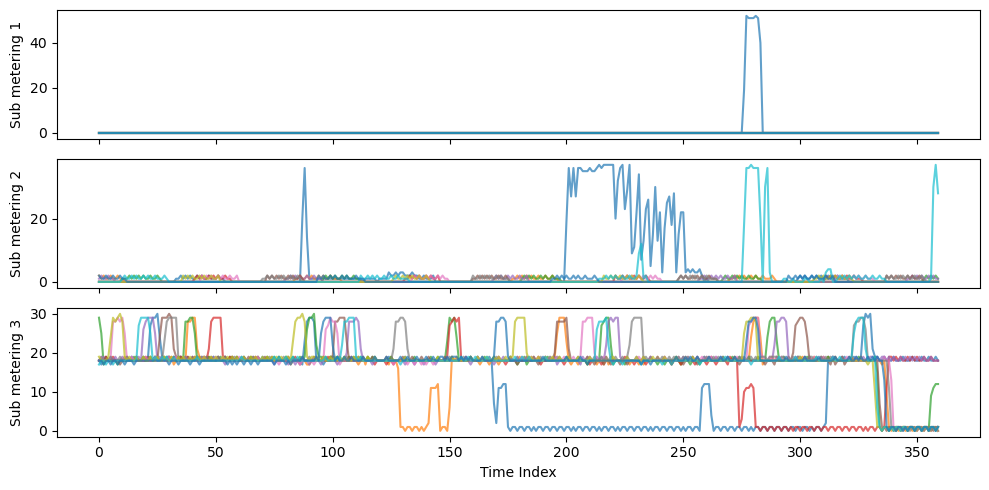

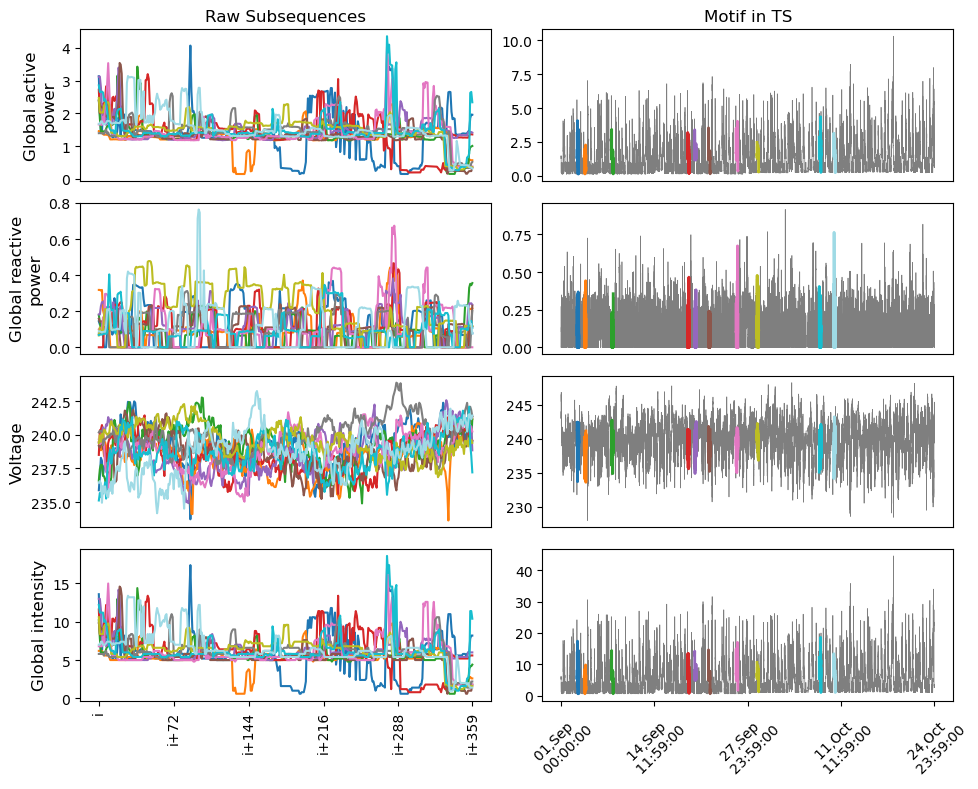

{'ID': 38, 'k': 4, 'Features': '1,0,2,3', 'm': 360, '#Matches': 57, 'Indices': '[39934, 3905, 52917, 71559, 24084, 26943, 25482, 9671, 63574, 75902, 55750, 18038, 33326, 41996, 58576, 19762, 65842, 31970, 30465, 62909, 67910, 34217, 42829, 66458, 47083, 29815, 31271, 5990, 51420, 16885, 7446, 34790, 61492, 24696, 29375, 69488, 53476, 11122, 17492, 74467, 16139, 20384, 54313, 21112, 21809, 60698, 15406, 43681, 43432, 45650, 36229, 70108, 56395, 62152, 13194, 235, 40558, 22598]', 'max(dists)': 42.116, 'min(dists)': 29.258, 'med(dists)': 38.992, 'CE': 0.061, 'Score Unified': 0.089, 'Explained Var(%)': 29.98, 'P': 2.961362741074481e-75, 'p-value': 0.0, 'Sig_Hochber': True}


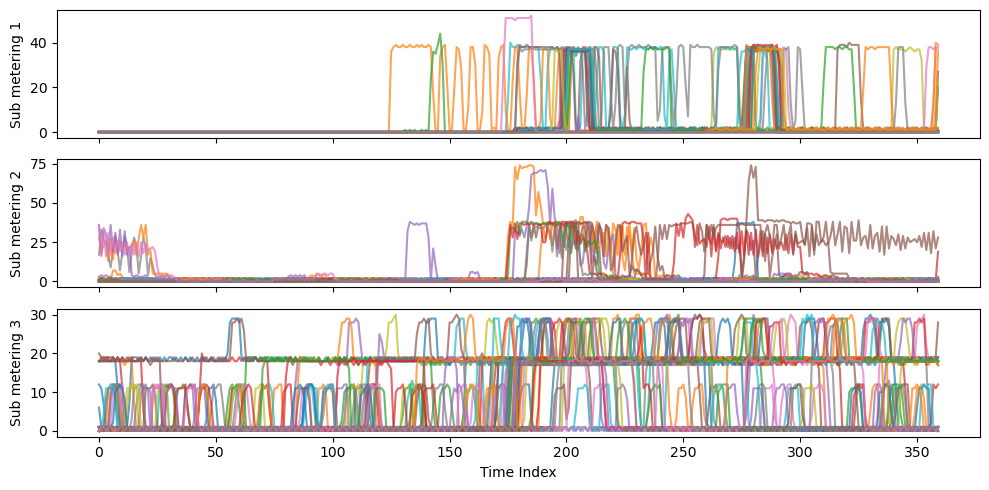

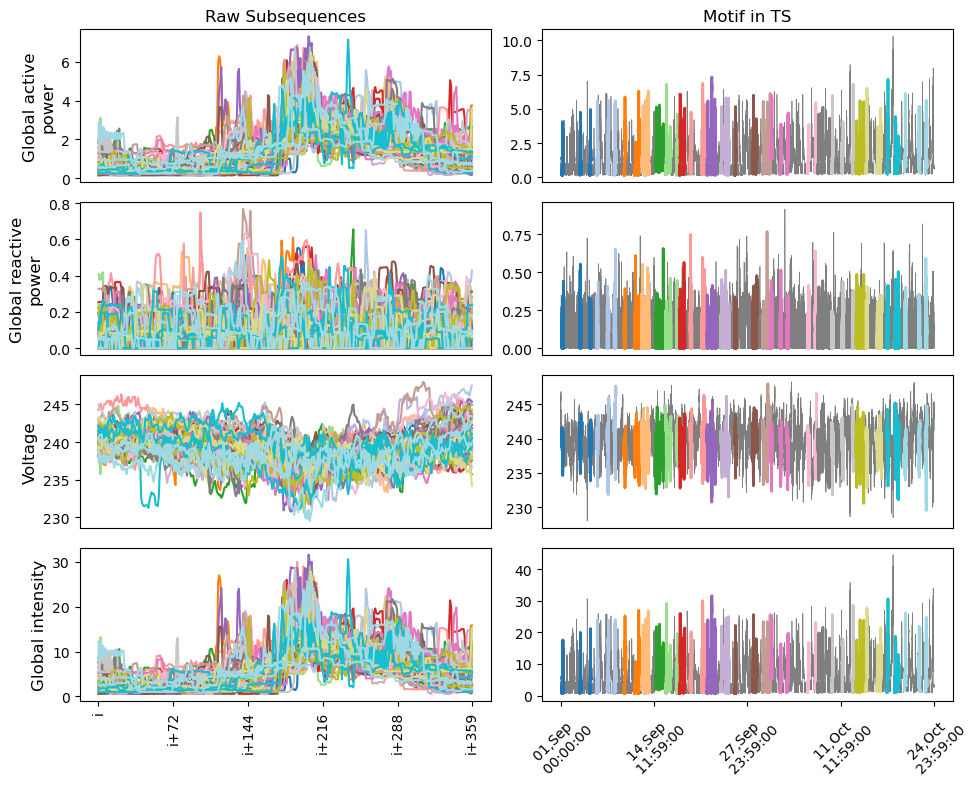

{'ID': 28, 'k': 4, 'Features': '1,0,2,3', 'm': 360, '#Matches': 28, 'Indices': '[13405, 46487, 30630, 53733, 50426, 40766, 447, 66667, 56707, 58012, 10480, 62358, 72509, 26312, 27792, 45035, 36396, 4804, 11954, 33530, 20544, 68124, 3413, 48336, 39578, 14810, 47386, 16267, 60904]', 'max(dists)': 33.269, 'min(dists)': 23.473, 'med(dists)': 30.271, 'CE': 0.082, 'Score Unified': 0.083, 'Explained Var(%)': 16.49, 'P': 4.2307529274618576e-85, 'p-value': 0.0, 'Sig_Hochber': True}


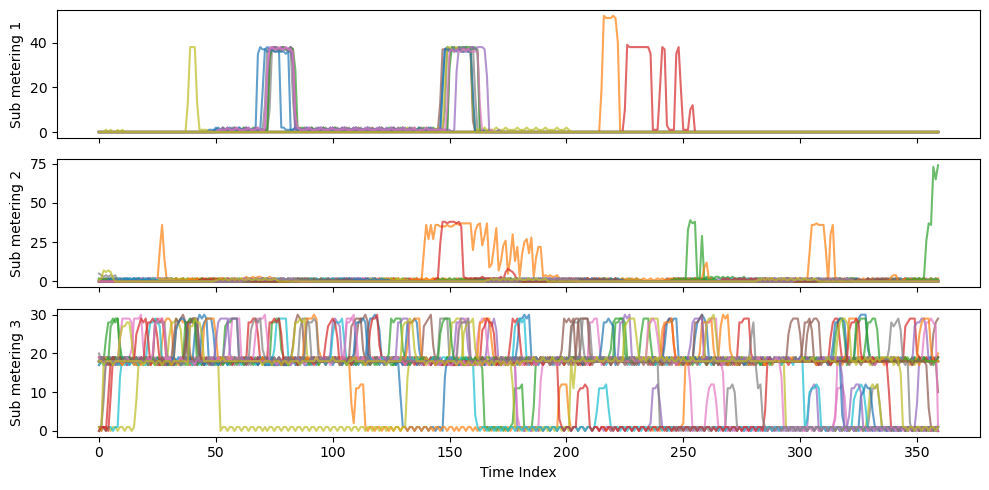

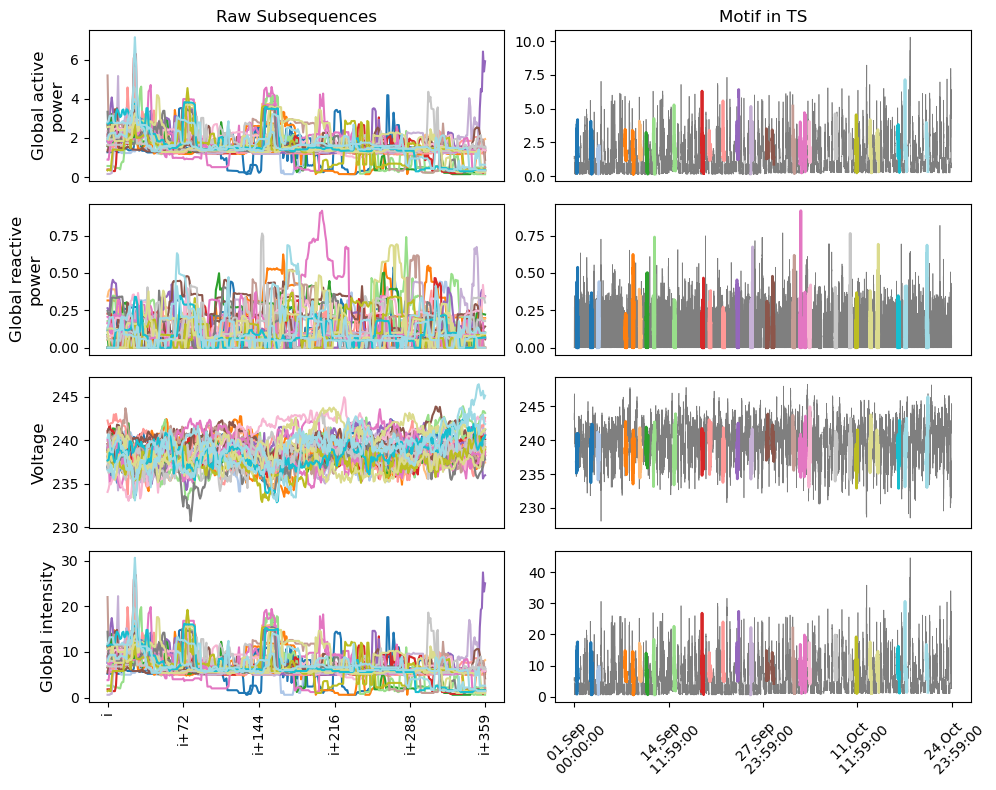

{'ID': 13, 'k': 4, 'Features': '1,0,3,2', 'm': 360, '#Matches': 4, 'Indices': '[60328, 74721, 71803, 24329, 40179]', 'max(dists)': 22.134, 'min(dists)': 18.527, 'med(dists)': 20.837, 'CE': 0.067, 'Score Unified': 0.077, 'Explained Var(%)': 1.99, 'P': 1.2925692344484736e-114, 'p-value': 0.0, 'Sig_Hochber': True}


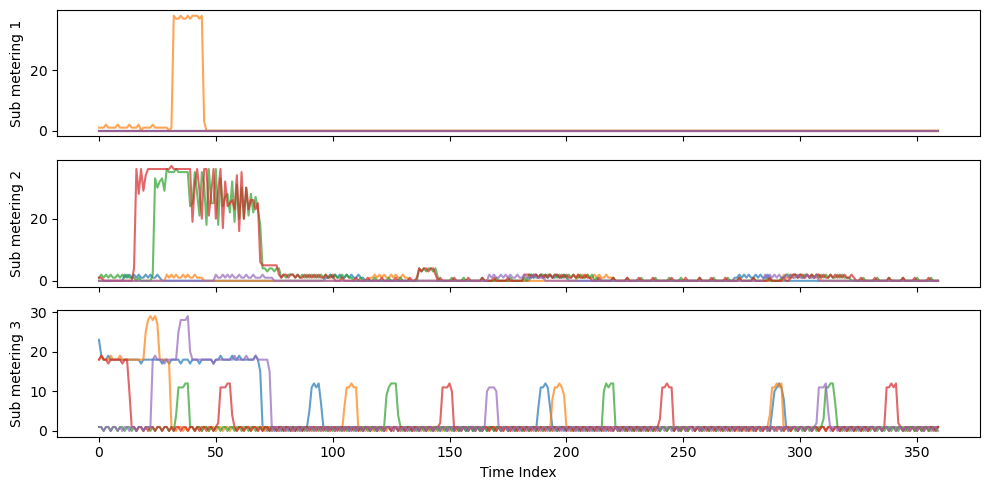

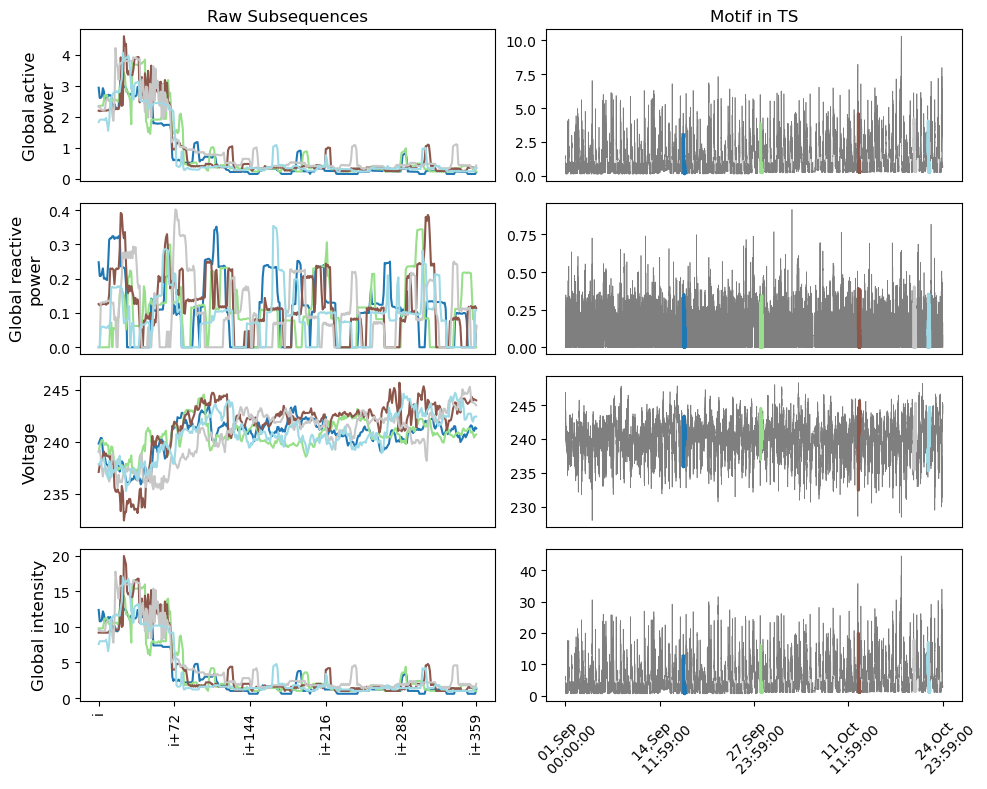

{'ID': 23, 'k': 4, 'Features': '1,0,2,3', 'm': 360, '#Matches': 27, 'Indices': '[53099, 43011, 19945, 40115, 55965, 29996, 67484, 2702, 4086, 34398, 63173, 35849, 54572, 27124, 17064, 41604, 5588, 64638, 21390, 44448, 76107, 60266, 24260, 9854, 71813, 73233, 31455, 49785]', 'max(dists)': 31.488, 'min(dists)': 21.21, 'med(dists)': 28.111, 'CE': 0.053, 'Score Unified': 0.075, 'Explained Var(%)': 12.82, 'P': 7.90592983499913e-75, 'p-value': 0.0, 'Sig_Hochber': True}


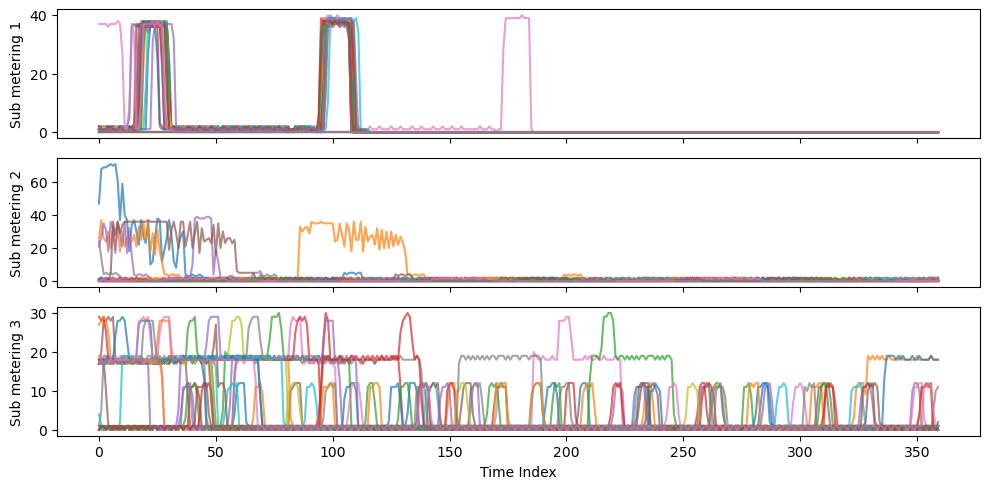

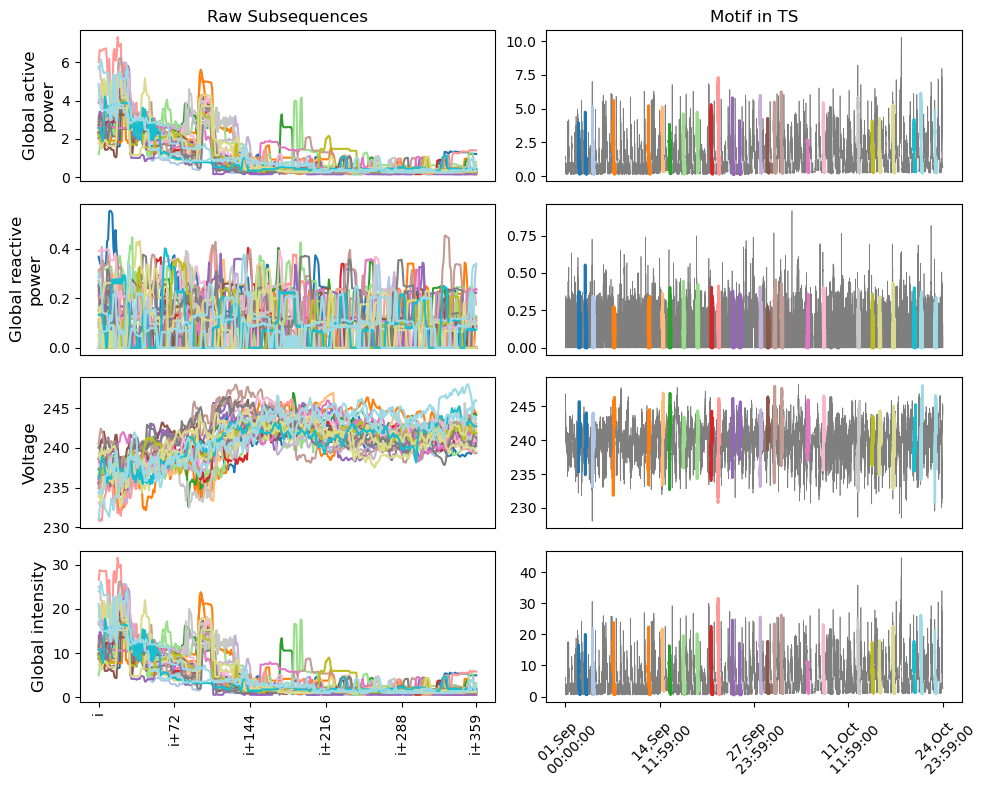

In [10]:
# Load motif statistics table
file_path = os.path.join(
    results_dir,
    f"table_motifs_normalize={normalize}_min_neighbors={min_neighbors}_max_distance={max_distance}_cutoff={cutoff}_max_matches={max_matches}_max_motifs={max_motifs}.csv",
)
mp_stats_table = pd.read_csv(file_path)

# Extract unique subsequence lengths
subsequence_lengths = mp_stats_table["m"].unique()

ts = data

# Loop over each subsequence length
for m in subsequence_lengths:
    logging.info(f"Motif length: {m}")

    # Filter motifs by current subsequence length
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)

    # Loop over each top motif
    for top_motif in top_motifs.to_dict(orient="records"):
        print(top_motif)

        # Parse dimensions and indices
        dimensions = sorted(map(int, top_motif["Features"].split(",")))
        indices = sorted(map(int, top_motif["Indices"].strip("[]").split(",")))

        # Extract feature names
        features = [df_data.columns[dimension] for dimension in dimensions]

        # Add label feature to the list
        ts_list = [df_data[feature].reset_index(drop=True) for feature in features]

        # Generate motif name
        motif_name = top_motif["ID"]

        # Create the figure and axes once, with 3 subplots for the submeters
        fig, ax = plt.subplots(figsize=(10, 5), nrows=3, sharex=True)

        # Loop over each index and plot the subsequences
        for indice in indices:
            subseq = labels.iloc[indice: indice + m]

            # Plot subsequences for each submeter in the same 3 subplots
            for i, feature in enumerate(labels.columns):
                ax[i].plot(subseq[feature].values, alpha=0.7)  # Plot with transparency to differentiate subsequences
                ax[i].set_ylabel(feature.replace("_", " "))  # Format the y-axis label for better readability

        # Set common x-axis labels and formatting
        ax[-1].set_xlabel("Time Index")  # Only set x-axis label on the bottom plot

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot (or save it, depending on your requirements)
        plt.show()

        features = [feature.replace("_", " ") for feature in features]

        # Plot and save the motif
        plot_motif(ts_list, features, m, indices, motif_name)